# Visual Inertial Odometry (VIO)

This project is intended to perform **VIO** with a set of stereo images collected from a UAV along its IMU data. The vehicle flew above a set of static obstacles in a Gazebo-based simulated environment.

<img src='assets/world.png' width=320 />

A trajectory was planned using QGroundControl where the vehicle moves along the different obstacles changing its height and position. Additionally, IMU data was also collected to fuse the Visual Odometry (VO) with an Error State Extended Kalman Filter **(ESKF)**. The experiment provides a CSV file with the ground truth of the trajectory, IMU data and the RGB/Depth images pair. The followig list shows how this project is arranged.

1. Visualizing the Ground Truth Trajectory
2. Importing images and Synchronyzing time-stamps.
3. Setting up feature detector-descriptor
4. Estimating VO trajectory with PNP
5. Fusing IMU and VO to estimate final trajectory.

Different util functions have been created in three different python files to carry out this task. *vis_tools.py* cointains all the plotting tools, *rotations.py* handles rotation matrices, quaternions and euler angles transformations in a simple way, finally, *dataset_handler.py* arranges the dataset of images in a comprehensive way and synchronize the time-stamp with the IMU data to allows sensor fusion.

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

from rotations import Quaternion, skew_symmetric
from vis_tools import *

import cv2
import glob
import os

# To avoid pandas warning
pd.set_option('mode.chained_assignment', None)

%matplotlib inline


## Visualize the Ground Truth

### Loading the Ground truth CSV file

All the ground truth files are located in *data/ground_truth/*, this file can be changed with your own experiment or other trajectory provided in the repository. Furthermore, two columns are dropped off the dataframe for better visualziation in this initial phase.

In [2]:
df = pd.read_csv('data/ground_truth/gt_4.csv')
df = df.drop(columns=['%time', 'field.header.seq'])
df.head()

,field.header.stamp,field.header.frame_id,field.child_frame_id,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z,field.pose.pose.orientation.x,field.pose.pose.orientation.y,field.pose.pose.orientation.z,field.pose.pose.orientation.w,...,field.twist.covariance26,field.twist.covariance27,field.twist.covariance28,field.twist.covariance29,field.twist.covariance30,field.twist.covariance31,field.twist.covariance32,field.twist.covariance33,field.twist.covariance34,field.twist.covariance35
0,3099790000000,map,base_link,-2.272085e-10,-0.000001,-5.690319e-08,0.000004,-6.680567e-10,-7.172958e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3099826000000,map,base_link,-2.181952e-10,-0.000001,-5.516272e-08,0.000004,-6.376270e-10,-7.177281e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3099862000000,map,base_link,-2.080562e-10,-0.000001,-5.343361e-08,0.000004,-6.034157e-10,-7.181184e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3099898000000,map,base_link,-1.977942e-10,-0.000001,-5.172694e-08,0.000004,-5.687984e-10,-7.184691e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3099934000000,map,base_link,-1.853152e-10,-0.000001,-5.004967e-08,0.000004,-5.267260e-10,-7.187730e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From the initial dataset two sets of features are established, one for the trajecory of the vehicle and another for the orientation of the vehicle throughout the test. These features are used to create two new dataframes out of the original one.

In [3]:
# Features for the trajetory of the UAV
pos_features = ['field.pose.pose.position.x', 'field.pose.pose.position.y', 'field.pose.pose.position.z']
# Features for the orientation of the UAV
orientation_features = ['field.pose.pose.orientation.x', 'field.pose.pose.orientation.y', 
                       'field.pose.pose.orientation.z', 'field.pose.pose.orientation.w']

In [4]:
# Dataframe with the ground truth trajecrory
position = df[pos_features]
position.head()

,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z
0,-2.272085e-10,-0.000001,-5.690319e-08
1,-2.181952e-10,-0.000001,-5.516272e-08
2,-2.080562e-10,-0.000001,-5.343361e-08
3,-1.977942e-10,-0.000001,-5.172694e-08
4,-1.853152e-10,-0.000001,-5.004967e-08


### Plotting trajectory

This plot shows the trajectory of the vehicle in the Gazeb-based simulation. Note that four plots are made, one with the 3D trajectory and 2d plots for each axis. This plots are intended to give an overall idea of what is happening with the vehicle while flying. 

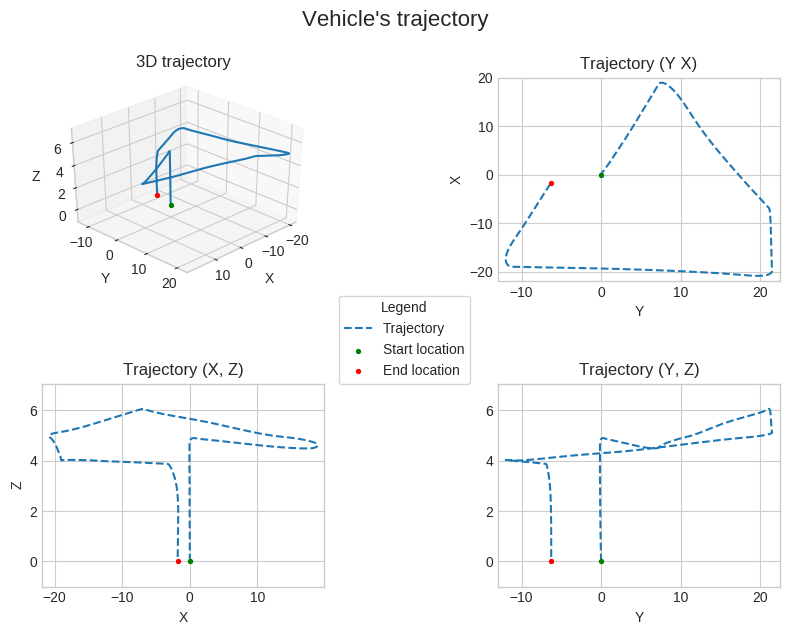

In [5]:
# Create a numpy array with the position dataframe for visualization purpose
list_of_pos = position.values.tolist()
list_of_pos = np.array(list_of_pos).T
# Plot the trajectory
visualize_trajectory(list_of_pos)

## 3D Geometry

To understand reference frames, this little sections aims to make clear the basic concepts. The next figure will be used to give a basic notation and properties of rotation matrices.

<img src='assets/rotationsT.png' width=320 />

### Vectors and reference frames

The notation of a coordinate frame is given by $\underrightarrow{\boldsymbol{\mathcal{F}}}_i$ where $i$ is the current coordinate frame. Similarly, $\underrightarrow{\boldsymbol{r}}^{vi}$ is a three position vector that points from coordinate frame $i$ to $v$. The equation below shows the three points in a position vector.

\begin{equation}
    r_i = \begin{bmatrix} r_1 \\ r_2 \\ r_3 \end{bmatrix}
\end{equation}

It is possible to do operations with position vectors. The dot product between two vector $\underrightarrow{r}$ and $\underrightarrow{s}$

\begin{equation}
    \underrightarrow{\boldsymbol{r}} \cdot \underrightarrow{\boldsymbol{s}} = \underrightarrow{\boldsymbol{r}}^T \cdot \underrightarrow{\boldsymbol{s}} = r_1s_1 + r_2s_2 + r_3s_2
\end{equation}

The cross product between two vector $\underrightarrow{r}$ and $\underrightarrow{s}$

\begin{equation}
    \underrightarrow{\boldsymbol{r}} \times \underrightarrow{\boldsymbol{s}} = \boldsymbol{r}_i^{\times}\boldsymbol{s}_i
\end{equation}

Where $\boldsymbol{r}_i^{\times}$ is the skew symetric. The skew symetris has a set of properties such as $(\boldsymbol{r}_i^{\times})^T = -\boldsymbol{r}_1^{\times}$

\begin{equation}
    \boldsymbol{r}_1^{\times} = \begin{pmatrix} 0 & -r_3 & r_2 \\ r_3 & 0 & -r_1 \\  -r_2 & r_1 & 0 \end{pmatrix}
\end{equation}

### Rotations

Rotations matrices are used to describe the relative orientation of one reference frame with respect to other. These matrices are denoted as $\boldsymbol{c}_{iv} \in \mathbb{R}^{3 \times 3}$ and it means that this rotation matrix comes from frame $i$ to frame $v$.

\begin{equation}
    \boldsymbol{c}_{iv} = \begin{pmatrix} c_{11} & c_{12} & c_{13} \\ c_{21} & c_{22} & c_{23} \\  c_{31} & c_{32} & c_{33} \end{pmatrix}
\end{equation}

Rotation matrices are orthogonal matrices, which means that their inverse is equal to their transpose $\boldsymbol{c}_{vi} = \boldsymbol{c}_{iv}^{-1} = \boldsymbol{c}_{iv}^{T}$. Using rotation matrices is possible to map points between different reference frames. Supposing that frame $i$ and $v$ are in the same position but with different orientation, point $p$ could be mapped as follows.

\begin{equation}
    r_i^{pi} = \boldsymbol{c}_{vi}^{-1} r_v^{pv} = \boldsymbol{c}_{iv} r_v^{pv}
\end{equation}

It is possible to perform operations between rotation matrices as follows.

\begin{equation}
    r_3 = \boldsymbol{c}_{32} r_2 = \boldsymbol{c}_{32} \boldsymbol{c}_{21} r_1
\end{equation}

\begin{equation}
    r_3 = \boldsymbol{c}_{31} r_1
\end{equation}

\begin{equation}
    \boldsymbol{c}_{31} = \boldsymbol{c}_{32} \boldsymbol{c}_{21}
\end{equation}

To map a point between reference frames in different positions use the next relation.

\begin{equation}
    \boldsymbol{r}_i^{pi} = \boldsymbol{r}_{i}^{vi} + \boldsymbol{c}_{iv} \boldsymbol{r}_{v}^{pv} 
\end{equation}

### Principal rotations

Rotation on each axis roll x $\theta$, pitch y $\beta$ and yaw z $\gamma$ are the principal rotations and are shown below.

\begin{equation}
    \boldsymbol{c}(\gamma) = \begin{pmatrix} cos(\gamma) & sin(\gamma) & 0 \\ -sin(\gamma) & cos(\gamma) & 0 \\  0 & 0 & 1 \end{pmatrix}, \boldsymbol{c}(\beta) = \begin{pmatrix} cos(\beta) & 0 & -sin(\beta) \\ 0 & 1 & 0 \\  sin(\beta) & 0 & cos(\beta) \end{pmatrix}, \boldsymbol{c}(\theta) = \begin{pmatrix} 1 & 0 & 0 \\ 0 & cos(\theta) & sin(\theta) \\  0 & -sin(\theta) & cos(\theta) \end{pmatrix}
\end{equation}

These rotations can be multiplied in the next form to create a different representation called Euler angles.

\begin{equation}
    \boldsymbol{c}(\gamma, \beta, \theta) =  \boldsymbol{c}_3(\gamma) \boldsymbol{c}_2(\beta) \boldsymbol{c}_1(\theta)
\end{equation}

### Quaternions

Quaternions are a different form to represent orientations. The parameters $\epsilon \in \mathbb{R}^{3 \times 1}$ and $\eta \in \mathbb{1}$ conform them. Below is the equation of a Quaternion where $\eta = cos(\phi/2)$ and $\epsilon = \hat{u} sin(\phi/2)$.

\begin{equation}
    \boldsymbol{q} = \begin{bmatrix} \epsilon \\ \eta \end{bmatrix} \in \mathbb{R}^{4 \times 1}
\end{equation}

Some of their properties are: $||q|| = 1$, $\boldsymbol{q}^T \boldsymbol{q} = 1$ and its inverse is given by

\begin{equation}
    \boldsymbol{q}^{-1} = \begin{bmatrix} -\epsilon \\ \eta \end{bmatrix} \in \mathbb{R}^{4 \times 1}
\end{equation}

It is possible to transform a Quaternion into a rotation matrix with the next equations.

\begin{equation}
    \boldsymbol{r}_b = \boldsymbol{C}(\boldsymbol{q}_{ba})\boldsymbol{r}_a
\end{equation}

\begin{equation}
    \boldsymbol{C}(q) = (\eta^2 - \boldsymbol{\epsilon}^T\boldsymbol{\epsilon})\mathbb{I} + 2\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T + 2\eta[\boldsymbol{\epsilon}]_{\times}
\end{equation}

Similarly, the product between two quaternions is given as follows.

\begin{equation}
    \boldsymbol{p} \otimes \boldsymbol{q}  = \begin{bmatrix} \boldsymbol{p}_\eta \boldsymbol{q}_\eta - \boldsymbol{p}_\epsilon^T \boldsymbol{q}_\epsilon \\ \boldsymbol{p}_\eta\boldsymbol{q}_\epsilon + \boldsymbol{q}_\eta \boldsymbol{p}_\epsilon + [\boldsymbol{p}_\epsilon]_{\times} \boldsymbol{q}_\epsilon \end{bmatrix}
\end{equation}

### Transformation matrices

These is a compact form to represent rotations + traslations between reference frames. One property of Transformation matrices is $\boldsymbol{T}_{iv} = \boldsymbol{T}_{ia} \boldsymbol{T}_{ab} \boldsymbol{T}_{bv}$, which is exactly the same of rotation matrices.

To map a point between different coordinate frames, the relation is given as follows.

\begin{equation}
    \begin{bmatrix} r_i^{pi} \\ 1 \end{bmatrix} = \begin{pmatrix} \boldsymbol{c}_{iv} & \boldsymbol{r}_i^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix} \begin{bmatrix} r_v^{pv} \\ 1 \end{bmatrix} = \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}
\end{equation}

Some of their properties are given below.

\begin{equation}
    \begin{bmatrix} r_v^{pv} \\ 1 \end{bmatrix} = \boldsymbol{T}_{iv}^{-1} \begin{bmatrix} r_i^{pi} \\ 1 \end{bmatrix} = \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}
\end{equation}

\begin{equation}
    \boldsymbol{T}_{iv}^{-1} = \begin{pmatrix} \boldsymbol{c}_{iv} & \boldsymbol{r}_i^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix}^{-1} = \begin{pmatrix} \boldsymbol{c}_{iv}^T & -\boldsymbol{c}_{iv}^T \boldsymbol{r}_i^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix} = \begin{pmatrix} \boldsymbol{c}_{vi} & -\boldsymbol{r}_v^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix} = \begin{pmatrix} \boldsymbol{c}_{vi} & \boldsymbol{r}_v^{iv} \\ \boldsymbol{0} & 1 \end{pmatrix} = \boldsymbol{T}_{vi}
\end{equation}

For further information about 3D Geometry and transformations between quaternions and other rotations' representations, see Chapter 6, Sections 1 to 3 [State estimation for Robotics](http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf). **Note**: the image was taken from this reference.

Read Chapter 6, Sections 1 to 3. Section 6.4 is about essential matrix
http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf
Read Section 5 of a technical report by
https://arxiv.org/pdf/1711.02508.pdf

### Creating orientations dafraframe and understanding its content

Let's first create a dataset that contains only the orientation of the vehicle while flying. The orientations are arranged as Quaternions, therefore, it is neccesary to convert them to Euler angles for better visualziation. 

In [6]:
# Dataframe with the ground truth orientation
orientation = df[orientation_features]
orientation.head()

,field.pose.pose.orientation.x,field.pose.pose.orientation.y,field.pose.pose.orientation.z,field.pose.pose.orientation.w
0,0.000004,-6.680567e-10,-7.172958e-12,1.0
1,0.000004,-6.376270e-10,-7.177281e-12,1.0
2,0.000004,-6.034157e-10,-7.181184e-12,1.0
3,0.000004,-5.687984e-10,-7.184691e-12,1.0
4,0.000004,-5.267260e-10,-7.187730e-12,1.0


In [7]:
# Create a numpy array with the orientation dataframe for visualization purpose
list_of_q = orientation.values.tolist()
list_of_q = np.array(list_of_q).T
# Exracting the first Quaternion of the list of quaternions
q_1 = list_of_q[:,0]
# Creating a Quaternion objec
q = Quaternion(w=q_1[3], x=q_1[0], y=q_1[1], z=q_1[2])
q

Quaternion (wxyz): [1.00000, 0.00000, -0.00000, -0.00000]

With *orientations.py* it is possible to handle rotations in a easy way. Using the methods **.mat** transform the current quaternion into a rotation matrix. Futhermore, **.to_euler** creates an euler angle representation of the Quaternion.

In [8]:
# Transform Quaternion into a rotation matrix
q.to_mat()

array([[1.0000000000005358, array([1.43401629e-11]),
        array([-1.33611348e-09])],
       [array([-1.43516677e-11]), 0.999999999963464,
        array([-8.61067467e-06])],
       [array([1.33611335e-09]), array([8.61067467e-06]),
        0.999999999963464]], dtype=object)

In [9]:
# Transform Quaternion into euler angles representation. The printing order is roll pitch and yaw
q.to_euler()

array([ 8.61067467e-06, -1.33611335e-09, -1.43516677e-11])

It is also possible to create a Quaternion representation out of euler angles or orientation matrices. For example, below is shown an example of how to transform euler angles into a Quaternion.

In [10]:
q = Quaternion(euler=q.to_euler())
q

Quaternion (wxyz): [1.00000, 0.00000, -0.00000, -0.00000]

### Plotting orientation

This plot shows the ground truth of the three euler angles **roll, pitch and yaw** during the flying test. 

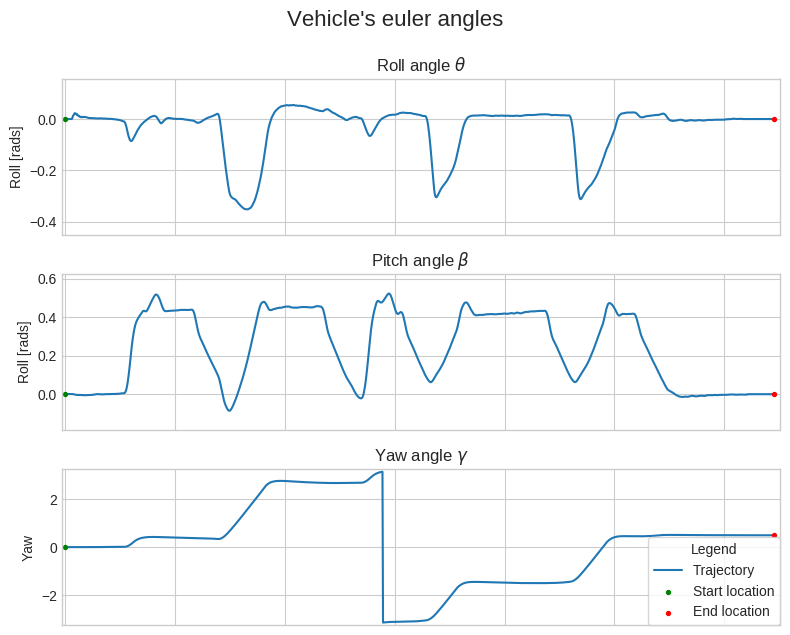

In [11]:
visualize_angles(list_of_q)

## Reading IMU data and preprocessing

Once we have a clear idea of how the vehicle moves, it is time to load the IMU data. If you want to change the test, just select a different test. The IMU data is located at **data/imu/**. First of all lets load the data and remove unnecessary information.

In [12]:
# Load IMU data and remove unnecessary columns
imu_df = pd.read_csv('data/imu/imu_1.csv')
imu_df = imu_df.drop(columns=['%time', 'field.header.seq'])
imu_df.head()

,field.header.stamp,field.header.frame_id,field.orientation.x,field.orientation.y,field.orientation.z,field.orientation.w,field.orientation_covariance0,field.orientation_covariance1,field.orientation_covariance2,field.orientation_covariance3,...,field.linear_acceleration.z,field.linear_acceleration_covariance0,field.linear_acceleration_covariance1,field.linear_acceleration_covariance2,field.linear_acceleration_covariance3,field.linear_acceleration_covariance4,field.linear_acceleration_covariance5,field.linear_acceleration_covariance6,field.linear_acceleration_covariance7,field.linear_acceleration_covariance8
0,2767050000000,base_link,0.009297,-0.011614,0.019162,-0.999706,1.0,0.0,0.0,0.0,...,9.849300,9.000000e-08,0.0,0.0,0.0,9.000000e-08,0.0,0.0,0.0,9.000000e-08
1,2767070000000,base_link,0.009270,-0.011677,0.019177,-0.999705,1.0,0.0,0.0,0.0,...,9.785671,9.000000e-08,0.0,0.0,0.0,9.000000e-08,0.0,0.0,0.0,9.000000e-08
2,2767090000000,base_link,0.009291,-0.011667,0.019163,-0.999705,1.0,0.0,0.0,0.0,...,9.759786,9.000000e-08,0.0,0.0,0.0,9.000000e-08,0.0,0.0,0.0,9.000000e-08
3,2767106000000,base_link,0.009286,-0.011659,0.019161,-0.999705,1.0,0.0,0.0,0.0,...,9.761782,9.000000e-08,0.0,0.0,0.0,9.000000e-08,0.0,0.0,0.0,9.000000e-08
4,2767130000000,base_link,0.009288,-0.011666,0.019163,-0.999705,1.0,0.0,0.0,0.0,...,9.799241,9.000000e-08,0.0,0.0,0.0,9.000000e-08,0.0,0.0,0.0,9.000000e-08


Create a list of features with the linear acceleration and angular velocity. These are the features needed to perform VIO.

In [13]:
imu_features = ['field.header.stamp', 'field.linear_acceleration.x', 'field.linear_acceleration.y', 
                'field.linear_acceleration.z', 'field.angular_velocity.x', 'field.angular_velocity.y',
                'field.angular_velocity.z']

final_imu_df = imu_df[imu_features]
final_imu_df.head()

,field.header.stamp,field.linear_acceleration.x,field.linear_acceleration.y,field.linear_acceleration.z,field.angular_velocity.x,field.angular_velocity.y,field.angular_velocity.z
0,2767050000000,-0.230043,-0.195316,9.849300,0.001881,-0.000283,-0.001114
1,2767070000000,-0.293606,-0.152798,9.785671,0.004810,0.000407,-0.000620
2,2767090000000,-0.228137,-0.168346,9.759786,-0.002333,-0.008564,0.003242
3,2767106000000,-0.271731,-0.184918,9.761782,0.002793,-0.006379,0.000433
4,2767130000000,-0.270553,-0.207317,9.799241,0.002288,-0.005186,0.001662


### Changing ROS time to seconds

As the CSV files are formatted with ROS time, here we change this notation to seconds. The first four numbers are the seconds and the rest are nano seconds. With this in mind, it is only necessary to divide the whole number by 1.000.000.000 (to separate the nanoseconds out of the seconds) and substract the minimum value, which is the timestamp of the first sample. These operations will create a seconds-time representation at each time step and they will be used to synchronize the images time-stamp.

In [14]:
# Get minimum value of timeStamp as an integer
minValue = np.floor(final_imu_df['field.header.stamp'].min() / 1000000000)
# Modify all the timestamp column values and format them with only two decimal numbers
final_imu_df['field.header.stamp'] = (final_imu_df['field.header.stamp'] / 1000000000) - minValue
final_imu_df['field.header.stamp'] = final_imu_df['field.header.stamp'].round(decimals=2)
final_imu_df.head()

,field.header.stamp,field.linear_acceleration.x,field.linear_acceleration.y,field.linear_acceleration.z,field.angular_velocity.x,field.angular_velocity.y,field.angular_velocity.z
0,0.05,-0.230043,-0.195316,9.849300,0.001881,-0.000283,-0.001114
1,0.07,-0.293606,-0.152798,9.785671,0.004810,0.000407,-0.000620
2,0.09,-0.228137,-0.168346,9.759786,-0.002333,-0.008564,0.003242
3,0.11,-0.271731,-0.184918,9.761782,0.002793,-0.006379,0.000433
4,0.13,-0.270553,-0.207317,9.799241,0.002288,-0.005186,0.001662


## Loading images

DatasetHandler is a class to ease the manipulation of RGB, Grayscale and Depth images. All the images are stored in different lists where the position zero is the time-stamp and position one the current image. In the constructor it is necessary to pass the processed IMU dataframe (with fixed time-stamps) to sync the time of both IMU data and images. The number of images and depth maps are automatically synchronized and there are equal number of images/depth maps.

In [15]:
from dataset_handler import DatasetHandler

In [16]:
# Create an object DatasetHandler 
images_dataset = DatasetHandler(img_path = 'images/test_4/', depth_path = 'depth/', imu_df = final_imu_df)

### Using the Dataset_handler's object

To load a Grayscale Image, use the class' attribute **.images[n]** where n is the index of the image. This Function will return two arguments, the current time-stamp and the image.

The time-stamp of the image 25 is: 5.83



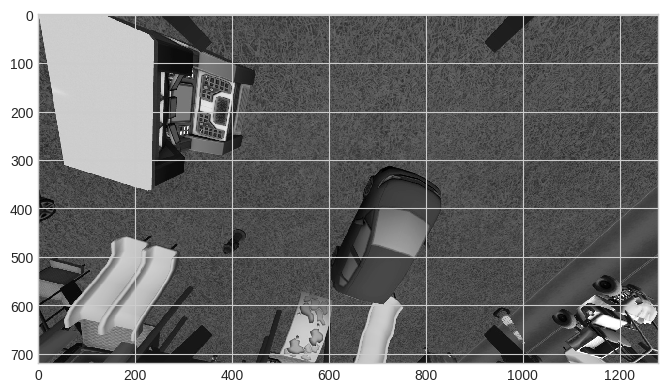

In [17]:
i = 25
# Load Grayscale image
time, gray_image = images_dataset.images[i]
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(cv2.bitwise_not(gray_image))
print("The time-stamp of the image {0} is: {1}\n".format(i, time))

To load an RGB Image, use the class' attribute **.images_rgb[n]**.

The time-stamp of the image 25 is: 5.83



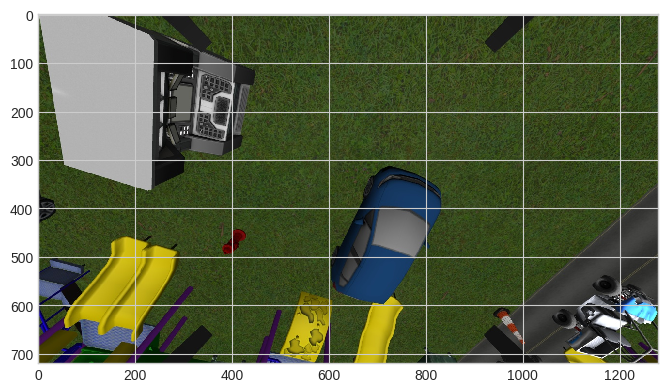

In [18]:
# Load RGB image
time, rgb_image = images_dataset.images_rgb[i]
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(rgb_image)
print("The time-stamp of the image {0} is: {1}\n".format(i, time))

To load a Depth map, use the class' attribute **.depth_maps[n].**

The time-stamp of the image 25 is: 5.83

The Maximum and minimum depth are: 9.565945625305176, 0.10083629190921783



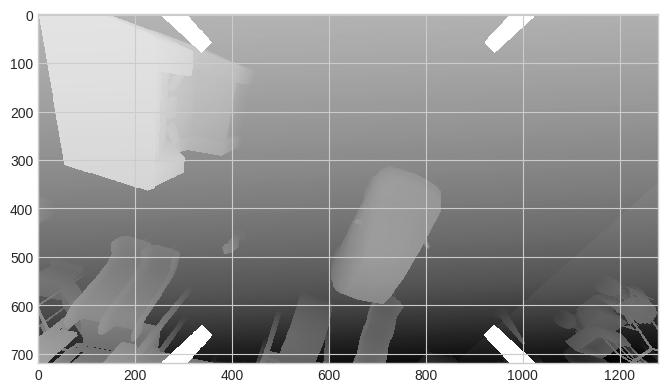

In [19]:
# Load Depth image
time, depth = images_dataset.depth_maps[i]
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth)
print("The time-stamp of the image {0} is: {1}\n".format(i, time))
print("The Maximum and minimum depth are: {0}, {1}\n".format(depth.max(), depth.min()))

Additional to the images, the DatasetHandler's object also contains the **camera calibration matrix**. This matrix can be used as follows.

In [20]:
images_dataset.k

array([[410.,   0., 640.],
       [  0., 410., 360.],
       [  0.,   0.,   1.]], dtype=float32)

## Setting up the transformation between frames.

To solve the **VO** problem, there is necessary to set up the transformations between the camera $C$, imu $I$ and navigation frame $n$. All the data is going to be plotted in the navigation frame.

<img src='assets/cam_imu.png' width=160 />

The rotation matrix between IMU and Camera frame $\boldsymbol{c}_{ic}$ is given by:

\begin{equation}
    \boldsymbol{c}_{ic} = \begin{pmatrix} 0 & -1 & 0 \\ -1 & 0 & 0 \\  0 & 0 & -1 \end{pmatrix}
\end{equation}

Similarly, the traslation vector $\boldsymbol{r}_i^{ci}$ between both frames is:

\begin{equation}
    r_i^{ci} = \begin{bmatrix} 0 \\ 0 \\ -0.013633 \end{bmatrix}
\end{equation}

Therefore, the transformation matrix between the imu frame and the camera is given by:

\begin{equation}
    \boldsymbol{T}_{ic} = \begin{pmatrix} 0 & -1 & 0 & 0\\ -1 & 0 & 0 & 0 \\  0 & 0 & -1 & -0.013633 \\  0 & 0 & 0 & 1 \end{pmatrix}
\end{equation}

If we want to compute the transformation $\boldsymbol{T}_{ci}$ from the camera frame to the IMU, the inverse transformation matrix $\boldsymbol{T}_{ic}$ is exactly the same to $\boldsymbol{T}_{ci}$.

Additionally, as the traslations will be recorded with respect the camera frame, it is necessary to set up an initial transformation between the navigation and camera frame. The relation between both frames is given by the next image.

<img src='assets/cam_nav.png' width=160 />

For the sake of simplicity, I assume that both frames (navigation and camera) are located in the same origin at time-stamp zero. Tehrefore, the transformation matrix $\boldsymbol{T}_{nc}$ will be given by.

\begin{equation}
    \boldsymbol{T}_{ic} = \begin{pmatrix} 0 & -1 & 0 & 0\\ -1 & 0 & 0 & 0 \\  0 & 0 & -1 & 0 \\  0 & 0 & 0 & 1 \end{pmatrix}
\end{equation}

Knowing the transformation between frames it is possible to solve the VO problem, stacking at each time-step the transformation matrices between consecutive camera poses and multypling this result by $\boldsymbol{T}_{ci}$ to obtain the result in the same coordinate frame as the IMU data and ground truth.

In [21]:
# Transformation matrix from camera frame to IMU
t_ci = np.array([[0, -1, 0, 0],
                 [-1, 0, 0, 0],
                 [0, 0, -1, -0.013633],
                 [0, 0, 0, 1]], dtype=np.float32)

## Masking the landing legs of the UAV

Before starting the VO process, I created a mask to avoid the detection of features within the landing legs of the UAV. If this legs are not masked, the trajectory will become very unstable owing to useless features in the legs.

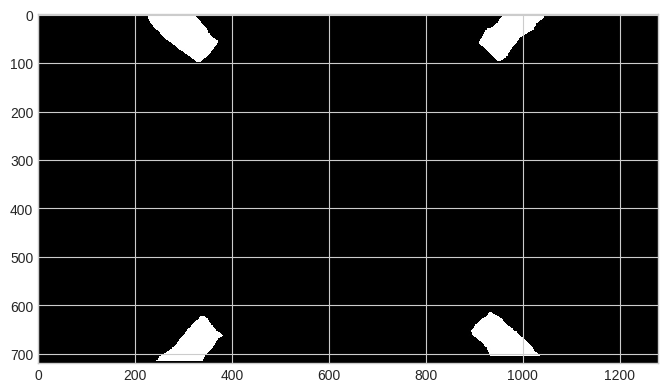

In [22]:
# Read the Mask to avoid the detection of features in the leg of the UAV
mask = cv2.bitwise_not(cv2.imread("images/mask_quad.jpg", 0))
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(mask)

## Visual Odometry

### Feature extraction

The first step is to extract relevant features from the current image frame. This can be accomplished with different detector-descriptors provided by OpenCV. A useful tutorial to understand this concepts is given [here](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html).

In [24]:
def extract_features(image, thresh = 200):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image
    thresh -- Threshold used for the detector (SURF)

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    
    # Create SURF object.
    # set extended to true to extract 128-dim descriptors.
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold = thresh, nOctaves = 4, nOctaveLayers = 3, extended = True)
    kp, des = surf.detectAndCompute(image, mask)  
    
    return kp, des

In [27]:
i = 30
ts, image = images_dataset.images[i]
# Modify the Threshold if you want
kp, des = extract_features(image, thresh = 300)

print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))
print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

Number of features detected in frame 30: 1797

Coordinates of the first keypoint in frame 30: (74.99112701416016, 187.00047302246094)


This method will plot the matches detected in the current image frame. This is only used for visualziation purpose. 

In [30]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)

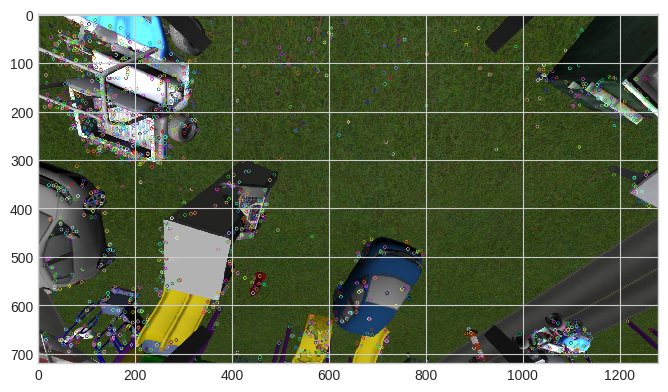

In [31]:
# visualizing and experimenting with various feature descriptors
times, image = images_dataset.images_rgb[i]
visualize_features(image, kp)

###  Extracting features from the whole dataset

This function extracts the features of the whole dataset of images using the last function.

In [42]:
def extract_features_dataset(images, extract_features_function, thresh = 200):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image
    thresh -- Threshold used for the detector (SURF)

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
        
    for i in range(images_dataset.num_frames):
        # Pass only the image images[i][1]
        kp, des = extract_features_function(images[i][1], thresh)
        
        kp_list.append(kp)
        des_list.append(des)
    
    return kp_list, des_list

In [43]:
# Store the Grayscale image in an object
images = images_dataset.images
kp_list, des_list = extract_features_dataset(images, extract_features, thresh = 200)
#images_dataset._pop_featureless(idx)
#images = images_dataset.images

i = 30
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 30: 2368
Coordinates of the first keypoint in frame 30: (74.99112701416016, 187.00047302246094)

Length of images array: 232


### Feature matching

Next step after extracting the features in each image is matching the features from the subsequent frames. It is very important that the descriptors passed are subsequent, otherwise, the feature matcher will probably fail.

In [44]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    match = bf.knnMatch(des1,des2, k=2)
    
    return match

In [45]:
i = 30
des1 = des_list[i]
des2 = des_list[i+1]

# Match the features of two subsequent image frames
match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

Number of features matched in frames 30 and 31: 2368


### Distance ratio application

To handle ambiguity between matches, the distance ratio method proposed by Lowis in 1999 is employed. This technique aims to improve the quality of the matches and maintain the best ones. The parameter *dist_threshold* is the maximum allowed relative distance between matches and the smaller this number is, the better the matches will be.

In [46]:
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
    while(True):
        filtered_match = [] 
        for m,n in match:
            if m.distance < dist_threshold*n.distance:
                filtered_match.append([m])

        # If there are less than 6 matches, increase the distance ratio
        # and loop again. 6 Matches have shown relative good results.
        if len(filtered_match) > 6:
            break

        dist_threshold += 0.05
            
    return filtered_match

In [47]:
i = 30 
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

print("Number of features matched in frames {0} and {1} before filtering by distance: {2}".format(i, i+1, len(match)))

# Distance ratio application
dist_threshold = 0.3 
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

Number of features matched in frames 30 and 31 before filtering by distance: 2368
Number of features matched in frames 30 and 31 after filtering by distance: 38


For visualization purpose, the next method will draw the matches between two consecutive images.

In [48]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatchesKnn(image1,kp1,image2,kp2,match, None,flags=2)
    
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

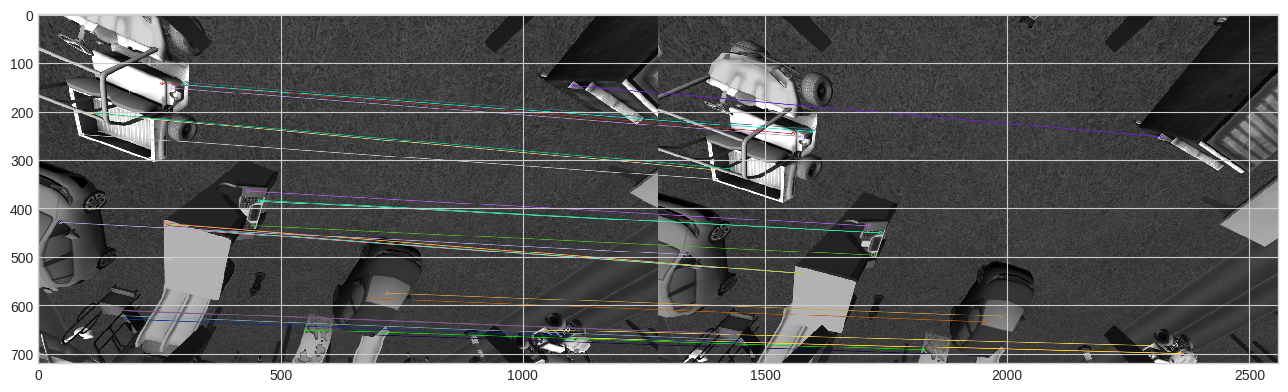

In [52]:
# Visualize n first matches, set n to None to view all matches
# set filtering to True if using match filtering, otherwise set to False
n = 30
filtering = True

i = 30 
times1, image1 = images_dataset.images[i]
times1, image2 = images_dataset.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.5
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

###  Matching features from the whole dataset

This function matches each subsequent image pair in the dataset.

In [53]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    for i in range(images_dataset.num_frames - 1):
        des1 = des_list[i]
        des2 = des_list[i + 1]
        #Features matcher 
        match = match_features(des1, des2)
        #Append matches
        matches.append(match)

    return matches

In [55]:
# Match all the images in the dataset
matches = match_features_dataset(des_list, match_features)
i = 30
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 30 and 31: 2368


The following method filter all the matches in the dataset with distance ratio application.

In [56]:
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    for i in range(len(matches)):
        match = filter_matches_distance(matches[i], dist_threshold)
        filtered_matches.append(match)
    
    return filtered_matches

In [57]:
# Distance ratio threshold
dist_threshold = 0.5
filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 30
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 30 and 31: 139


## Motion Estimation

To estimate the motion of the UAV using VO, it is necessary to recall the simplified camera model given in the image below.

<img src='assets/camera_model.png' width=320 />

\begin{equation}
    s \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = K [R | t] \begin{bmatrix} X_w \\ Y_w \\ Z_w \\ 1 \end{bmatrix}
\end{equation}

\begin{equation}
    s \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \end{bmatrix} \begin{bmatrix} X_w \\ Y_w \\ Z_w \\ 1 \end{bmatrix}
\end{equation}

Where $k$ is the calibration matrix and $[R | t]$ are the rotation and traslation vector we want to estimate. Similarly, the pixel points $(u, v)$ can be mapped again to camera coordinates knowing the scale given by the stereo camera. Using the depth of the stereo camera for a given point, it is possible to map pixel coordinates yo camera coordinates given the following equation.

\begin{equation}
    \begin{bmatrix} X_c \\ Y_c \\ Z_c \end{bmatrix} = Z_c \times (K^{-1} \begin{bmatrix} u \\ v \\ 1  \end{bmatrix})
\end{equation}

All this information is used in the solvePnPRansac method which estimates the rotation and traslation $[R | t]$ between two consecutive image frames given a set of 3d points at time-step $t-1$ and their correspondences in pixel frames at time-step $t$

For more information see [here](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html). **Note** Image taken from the last reference. 

In [49]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    objectpoints = []
    imagepoints = []
    
    ### START CODE HERE ###
    
    #this for acced to each ROW of the descriptor vector e.g (240 x 180) and extract relevant information from each row
    
    for m in match:
        #m is a list of one position, to acced to it i have to do m[0]
        m = m[0]
        # Index of the descriptor and feature in the first image
        query_idx = m.queryIdx #This is the first image indexes
        # Index of the descriptor and feature in the second image
        train_idx = m.trainIdx #This is the second image indexes
                
        # get first img 3d data (with depth)
        p1_x, p1_y = kp1[query_idx].pt
        image1_points.append([p1_x, p1_y])
        
        # get second img 2d data
        p2_x, p2_y = kp2[train_idx].pt
        image2_points.append([p2_x, p2_y])
        
        p1_z = depth1[int(p1_y), int(p1_x)]
        
        if p1_z < 900:
            # Transform points from image coordinate frame to camera frame
            scaled_coord = np.dot(np.linalg.inv(k), np.array([p1_x, p1_y, 1]))
            # Map the homogeneous coordinates to cartesian
            p1_3d = scaled_coord * p1_z
            # Save the camera 3d point
            objectpoints.append(p1_3d)
            # get second img 2d data
            p2_x_, p2_y_ = kp2[train_idx].pt
            imagepoints.append([p2_x_, p2_y_])
        else:
            continue
            
    # Transpose 3D points to feed it into pnp        
    objectpoints = np.array(objectpoints)
    # 2D Points of the second image
    imagepoints = np.array(imagepoints)

    # Solve with PNP CV_EPNP # SOLVEPNP_EPNP
    _, rvec, tvec, _ = cv2.solvePnPRansac(objectpoints, imagepoints, k, distCoeffs = None, flags=cv2.SOLVEPNP_ITERATIVE, 
                                          iterationsCount = 10000, reprojectionError = 2.0)
    #_, rvec, tvec = cv2.solvePnP(objectpoints, imagepoints, k, distCoeffs = None)
    
    rmat, _ = cv2.Rodrigues(rvec)
   
    ### END CODE HERE ###
    
    return rmat, tvec, image1_points, image2_points

In [50]:
i = 180
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = images_dataset.k
td, depth = images_dataset.depth_maps[i]
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 0.99929677 -0.02200777  0.03035826]
 [ 0.02109467  0.99932498  0.03007652]
 [-0.03099969 -0.02941497  0.99908647]]
Estimated translation:
 [[-0.03825779]
 [ 0.70547559]
 [ 0.29667137]]


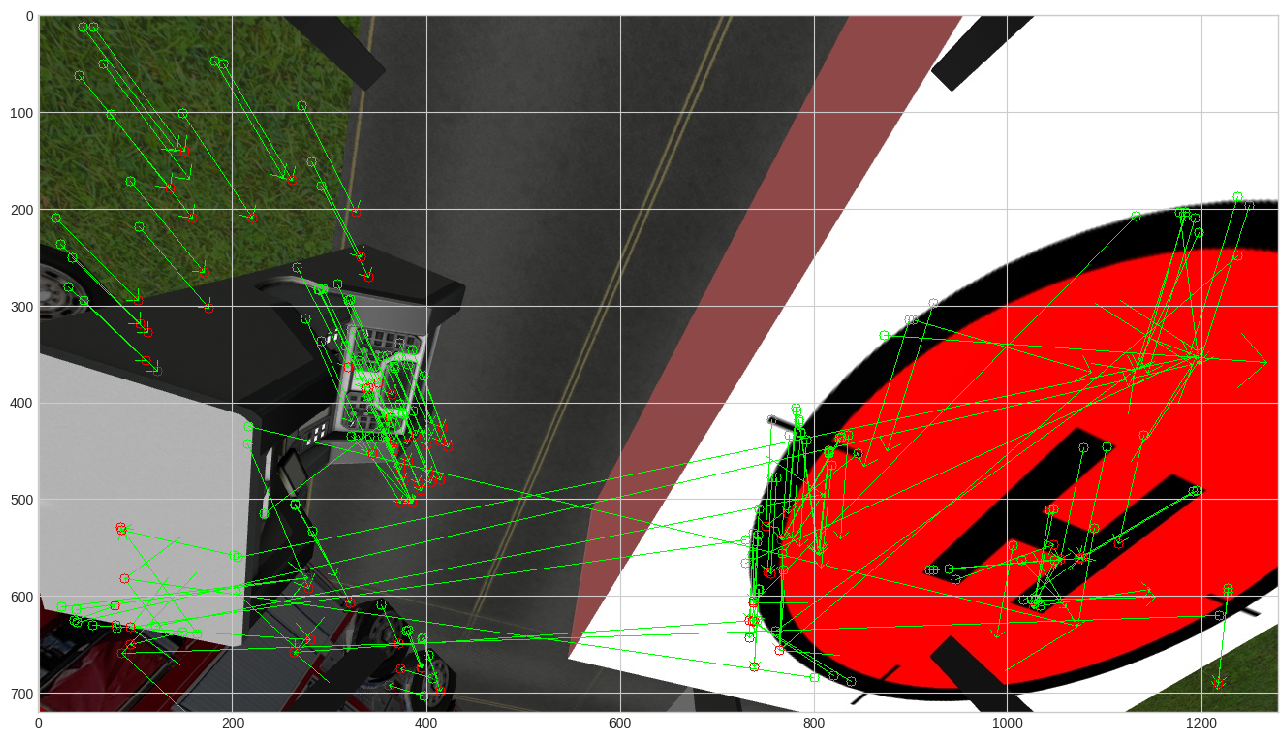

In [52]:
i=180
times1, image1  = images_dataset.images_rgb[i]
times1, image2 = images_dataset.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

In [53]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    trajectory = [np.array([0, 0, 0])]
    timestamp = [0]
    P = np.array([[0, -1, 0, 0],
                 [-1, 0, 0, 0],
                 [0, 0, -1, 0],
                 [0, 0, 0, 1]], dtype=np.float32)
    P_i = np.eye(4)
    
    for i in range(len(matches)):
        #Extract relevant information of the matches, and features from image i to i + 1
        match = matches[i]
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        _, depth = depth_maps[i]

        rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth)
        R = rmat
        t = np.array([tvec[0,0],tvec[1,0],tvec[2,0]])
        
        
        # Invert transformation matrix to point from frame i to  i+1
        P_new = np.eye(4) #New P Matrix
        P_new[0:3,0:3] = R.T #Rotated rotation matrix to point from the world to camera and change it to camera - world
        P_new[0:3,3] = (-R.T).dot(t) #Translation vector to point from image plane to world plane frames
        # Stack transformation matrices
        if np.abs(t.max()) < 5 and np.abs(t.min()) < 5:
            P = P.dot(P_new) #Dot product to add the matrices
            # Find trajectory to imu at each time step
            P_i = P.dot(t_ci)
            trajectory.append(P_i[:3,3])
            timestamp.append(images_dataset.images[i+1][0])
        else:
            print('Valor muy alto ' + str(i))
            print(t.min())
            print(t.max())

    trajectory = np.array(trajectory).T #this gives a 3 x Images matrix
    #print(trajectory[:,0])
    #print('With negative z')
    #trajectory[2,:] = -1*trajectory[2,:]
    #print((trajectory[:,0]))
    #print('Step changed')
     
    return trajectory, timestamp

In [55]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#images_dataset = DatasetHandler(img_path = 'images/test_4/', depth_path = 'depth/', imu_df = final_imu_df)


# Part 1. Features Extraction
images = images_dataset.images
kp_list, des_list = extract_features_dataset(images, extract_features, thresh = 100)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.7 # (0.5 - 100)
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches

    
# Part III. Trajectory Estimation
depth_maps = images_dataset.depth_maps
trajectory, timestamp = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps)


# Print trajectory
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[ 0.00000000e+00  2.03625137e-06 -3.09282975e-05  1.00372659e-04
  -1.39854846e-03 -5.19371653e-03 -1.03148270e-02 -1.70909535e-02
  -2.44840157e-02 -3.24163032e-02 -4.05427037e-02 -4.77191328e-02
  -5.40902412e-02 -6.07796990e-02 -6.66718228e-02 -7.05465459e-02
  -7.65716984e-02 -7.97633865e-02 -8.23816312e-02 -8.35639802e-02
  -8.28832597e-02 -7.55334932e-02 -2.59240258e-02  1.00517563e-01
   3.17559827e-01  6.24277325e-01  1.01395309e+00  1.48112231e+00
   2.01931316e+00  2.62654534e+00  3.30711230e+00  4.04879164e+00
   4.82202865e+00  5.60570231e+00  6.39342937e+00  7.18217077e+00
   7.97195015e+00  8.76498762e+00  9.56291907e+00  1.03654207e+01
   1.11699300e+01  1.19804203e+01  1.27888725e+01  1.35964172e+01
   1.43653639e+01  1.50854935e+01  1.57508853e+01  1.63607800e+01
   1.69171825e+01  1.74177784e+01  1.78635099e+01  1.82526940e+01
   1.85768020e+01  1.87982549e+01  1.89121242e+01  1.89105811e+01
   1.88100987e+01  1.86243359e+01  1.83704342e+01  1.80475153

(3, 232)


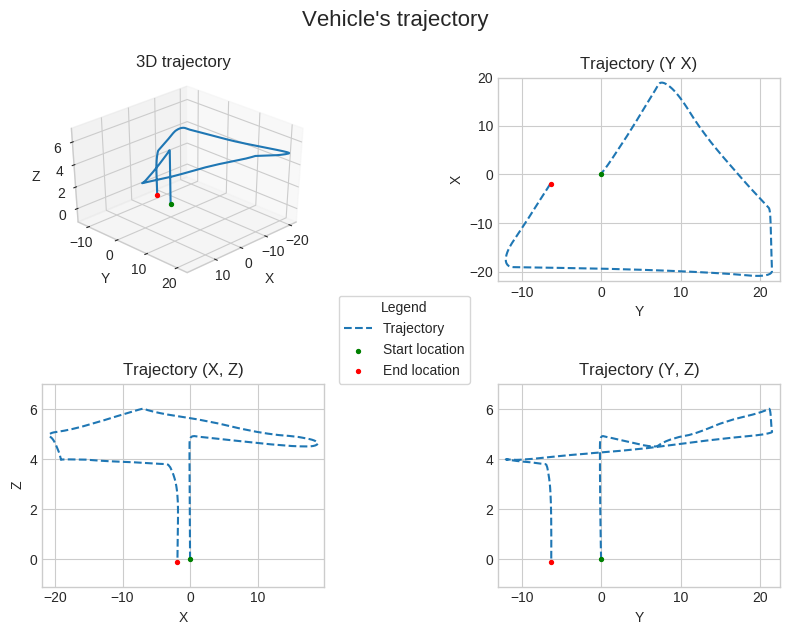

232


In [56]:
print(trajectory.shape)
visualize_trajectory(trajectory)
print(len(timestamp))

In [ ]:
visualize_trajectory(list_of_pos)

In [ ]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], label='Estimated')
ax.plot(list_of_pos[0,:], list_of_pos[1,:], list_of_pos[2,:], label='Ground Truth')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Final Estimated Trajectory')
ax.legend()
ax.set_zlim(-1, 10)
plt.tight_layout()
plt.show()

In [45]:
c_ci

array([[ 0.      , -1.      ,  0.      ,  0.      ],
       [-1.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -1.      , -0.013633],
       [ 0.      ,  0.      ,  0.      ,  1.      ]], dtype=float32)

In [46]:
final_imu_df.head()

,field.header.stamp,field.linear_acceleration.x,field.linear_acceleration.y,field.linear_acceleration.z,field.angular_velocity.x,field.angular_velocity.y,field.angular_velocity.z
0,0.05,-0.230043,-0.195316,9.849300,0.001881,-0.000283,-0.001114
1,0.07,-0.293606,-0.152798,9.785671,0.004810,0.000407,-0.000620
2,0.09,-0.228137,-0.168346,9.759786,-0.002333,-0.008564,0.003242
3,0.11,-0.271731,-0.184918,9.761782,0.002793,-0.006379,0.000433
4,0.13,-0.270553,-0.207317,9.799241,0.002288,-0.005186,0.001662


## IMU list

In [47]:
imu = final_imu_df.values.tolist()
imu = np.array(imu).T
#imu[0:2, :] = imu[0:2, :] / 5
#imu[1, :] = imu[1, :] - imu[1, 0]
#imu[2, :] = imu[2, :] * -1
#imu[3, :] = imu[3, :] * -1    
#imu[5, :] = imu[5, :] * -1 
#imu[6, :] = imu[6, :] * -1 
imu[1:4, 3]

array([-0.27173132, -0.18491791,  9.76178169])

In [48]:
#w=q_1[3], x=q_1[0], y=q_1[1], z=q_1[2]
list_of_ori[:,0]

array([ 5.43017160e-06, -7.75689937e-10, -8.34721053e-12,  1.00000000e+00])

In [49]:
from numpy.linalg import inv

var_imu_f = 0.1
var_imu_w = 1.0
var_cam = 1.0 #0.01

################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

#### 3. Initial Values #########################################################################

################################################################################################
# Let's set up some initial values for our ES-EKF solver.
################################################################################################
p_est = np.zeros([imu[0,:].shape[0], 3])  # position estimates
v_est = np.zeros([imu[0,:].shape[0], 3])  # velocity estimates
q_est = np.zeros([imu[0,:].shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu[0,:].shape[0], 9, 9])  # covariance matrices at each timestep
 
# Set initial values
p_est[0] = list_of_pos[:,0]
v_est[0] = np.zeros(3)
q_est[0] = Quaternion(w=list_of_ori[:,0][3], x=list_of_ori[:,0][0], y=list_of_ori[:,0][1], z=list_of_ori[:,0][2]).to_numpy()
p_cov[0] = np.eye(9)  # covariance of estimate
cam_i = 1 #Counter for the GNSS


#### 4. Measurement Update #####################################################################

################################################################################################
# Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make
# a function for it.
################################################################################################
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    # 3.1 Compute Kalman Gain
    R = np.diag([sensor_var, sensor_var, sensor_var]) # Measurement covariance matrix calculation

    K = p_cov_check.dot(h_jac.T).dot(inv(h_jac.dot(p_cov_check).dot(h_jac.T) + R)) #Kalman gain calculation

    # 3.2 Compute error state
    error_x = K.dot(y_k - p_check) #Error state computation

    # 3.3  Correct predicted state
    p_check = p_check + error_x[0:3] 
    v_check = v_check + error_x[3:6]
    q_check = Quaternion(axis_angle = error_x[6:9]).quat_mult(q_check)

    # 3.4 Compute corrected covariance
    p_cov_check = (np.eye(9) - K.dot(h_jac)).dot(p_cov_check)

    return p_check, v_check, q_check, p_cov_check


#### 5. Main Filter Loop #######################################################################

################################################################################################
# Now that everything is set up, we can start taking in the sensor data and creating estimates
# for our state in a loop.
################################################################################################
p_check = p_est[0] #Position check
v_check = v_est[0] #Position check
q_check = q_est[0]
p_cov_check = p_cov[0]

f_jac = np.eye(9) #F matrix initialization
Q_imu = np.diag([var_imu_f, var_imu_f, var_imu_f, var_imu_w, var_imu_w, var_imu_w]) # Q variance matrix

for k in range(1, imu[0,:].shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu[0, k] - imu[0, k - 1]

    # 1. Update state with IMU inputs

    C_ns = Quaternion(*q_check).to_mat() #Rotation matrix associated with the current vehicle pose (Computed from the quaternion)

    p_check = p_check + (delta_t * v_check) + (((delta_t**2) / 2) * (C_ns.dot(imu[1:4, k - 1]) + g)) # Position calculation
    v_check = v_check + (delta_t * (C_ns.dot(imu[1:4, k - 1]) + g)) #velocity calculation
    q_check = Quaternion(axis_angle = imu[4:7, k - 1] * delta_t).quat_mult(q_check) #Quaternion calculation (Current orientation)

    # 1.1 Linearize Motion Model
    F = f_jac # F matrix value assignation
    F[0:3,3:6] = np.eye(3) * delta_t 
    #F[3:6,6:9] = -1 * skew_symmetric(C_ns.dot(imu[1:4, k - 1])) * delta_t 
    F[3:6,6:9] = -1 * C_ns.dot(skew_symmetric(imu[1:4, k - 1])) * delta_t # This line is the forum suggestion and works much better
    F[6:9,6:9] = Quaternion(axis_angle = imu[4:7, k - 1] * delta_t).to_mat().T # This line is the forum suggestion and works much better

    Q = Q_imu * (delta_t**2) # Variance calculation in discrete time

    # 2. Propagate uncertainty
    p_cov_check = F.dot(p_cov_check).dot(F.T) + l_jac.dot(Q).dot(l_jac.T) #Variance calculation

    # 3. Check availability of GNSS and LIDAR measurements 55 or 49
    if cam_i < len(timestamp):
        if imu[0, k] == timestamp[cam_i]: # Measurement por GNSS
            p_check, v_check, q_check, p_cov_check = measurement_update(var_cam, p_cov_check, trajectory[:,cam_i], p_check, v_check, q_check)
            cam_i = cam_i + 1


    p_est[k] = p_check
    v_est[k] = v_check
    q_est[k] = q_check
    p_cov[k] = p_cov_check

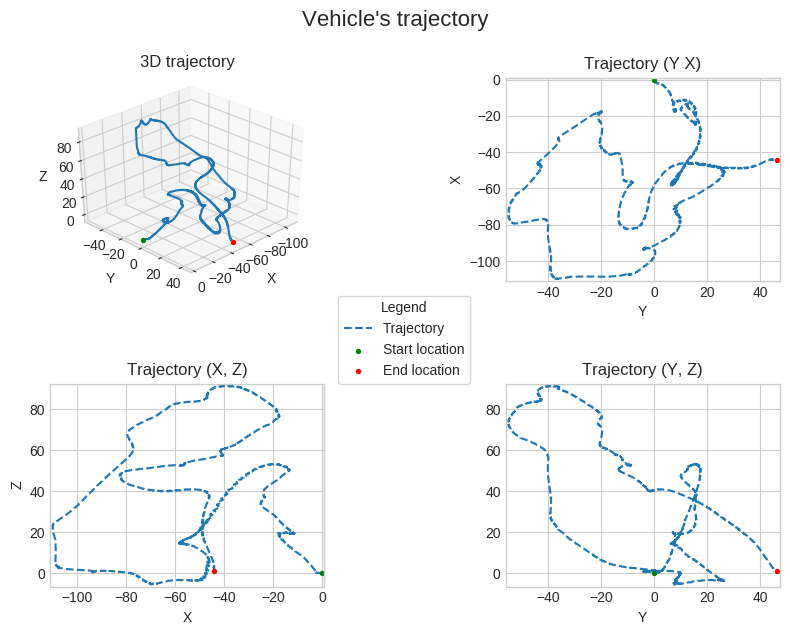

In [50]:
final_p = p_est.T
visualize_trajectory(final_p)

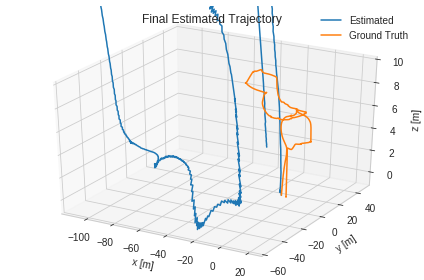

In [51]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(list_of_pos[0,:], list_of_pos[1,:], list_of_pos[2,:], label='Ground Truth')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Final Estimated Trajectory')
ax.legend()
ax.set_zlim(-1, 10)
plt.tight_layout()
plt.show()